In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

/kaggle/input/fake-news-detection-dataset/Task3_english_training.csv
/kaggle/input/fake-news-detection-dataset/Task3_english_dev.csv
/kaggle/input/fake-news-detection-dataset/English_data_test_release_with_rating.csv


In [2]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from datasets import Dataset, DatasetDict
from torch import nn
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score
)

2024-05-14 19:44:27.565394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 19:44:27.565504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 19:44:27.696021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_train = pd.read_csv('/kaggle/input/fake-news-detection-dataset/Task3_english_training.csv')
data_validation = pd.read_csv('/kaggle/input/fake-news-detection-dataset/Task3_english_dev.csv')
data_test = pd.read_csv('/kaggle/input/fake-news-detection-dataset/English_data_test_release_with_rating.csv')

combined_df = pd.concat([data_train, data_validation, data_test], ignore_index=True)
train_df, test_df = train_test_split(combined_df, test_size=0.20, random_state=27)

train_df['our rating'] = train_df['our rating'].str.lower()
test_df['our rating'] = test_df['our rating'].str.lower()

train_df = train_df[['text', 'title', 'our rating']].copy()
test_df = test_df[['text', 'title', 'our rating']].copy()

train_ds = train_df.reset_index(drop=True)
test_ds = test_df.reset_index(drop=True)

combined_df.head()

,public_id,text,title,our rating,ID
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",FALSE,NaN
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,partially false,NaN
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,partially false,NaN
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,FALSE,NaN
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,FALSE,NaN


In [4]:
train_ds.isna().sum()

text           0
title         22
our rating     0
dtype: int64

In [5]:
test_ds.isna().sum()

text          0
title         1
our rating    0
dtype: int64

In [6]:
def create_new_text(row):
    return row["title"] + " " + row["text"]

train_ds["title"] = train_ds["title"].fillna("")
train_ds["text"] = train_ds.apply(create_new_text, axis=1)

test_ds["title"] = test_ds["title"].fillna("")
test_ds["text"] = test_ds.apply(create_new_text, axis=1)

train_ds = train_ds[['text', 'our rating']].copy()
test_ds = test_ds[['text', 'our rating']].copy()

In [7]:
import re
import nltk
from nltk.corpus import stopwords
import emoji

nltk.download('stopwords')

def preprocess_text(text, remove_hashtags=False, remove_users=False, remove_urls=True, lower_case=True, remove_stopwords=True):
    text = emoji.demojize(text, language='en')
    words = []
    
    if lower_case:
        text = text.lower()
    
    if remove_hashtags:
        words = [word for word in words if not word.startwith('#')]
        text = ' '.join(words)
    
    if remove_users:
        words = [word for word in words if not word.startwith('@')]
        text = ' '.join(words)
        
    if remove_urls:
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)
        
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        
    return text

train_ds["text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       study: marijuana could be making teens less in...
1       bill clinton military tribunal: day 1 william ...
2       david cameron still wants to push for airstrik...
3       a small team of israeli scientists think they ...
4       3 lions led by donkeys fury as cold-blooded fi...
                              ...                        
1495    sudden surge in stillbirths and menstrual chan...
1496    exclusive: russian losses in syria jump in 201...
1497    fda takes key action in fight against covid-19...
1498    where’s zinke? the interior secretary’s specia...
1499    the cdc has admitted face masks do little to p...
Name: text, Length: 1500, dtype: object

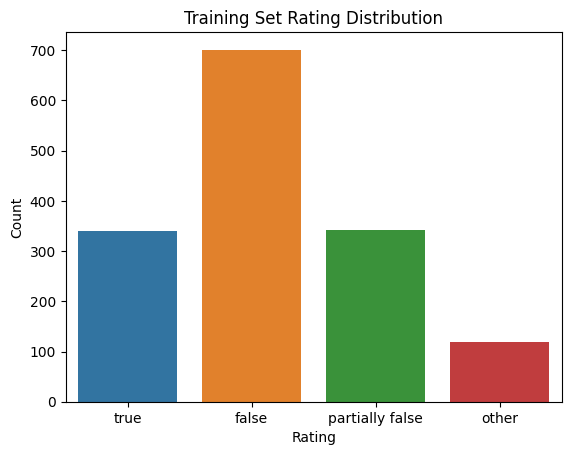

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rating_distribution(df, title):
    sns.countplot(x='our rating', data=df)
    plt.title(title)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

plot_rating_distribution(train_df, 'Training Set Rating Distribution')

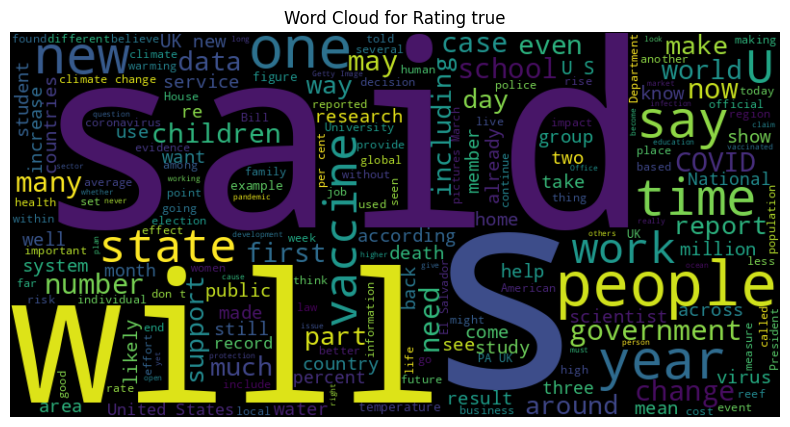

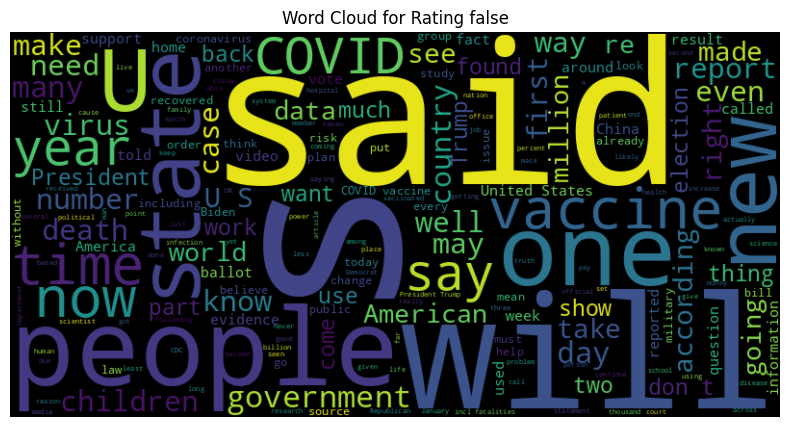

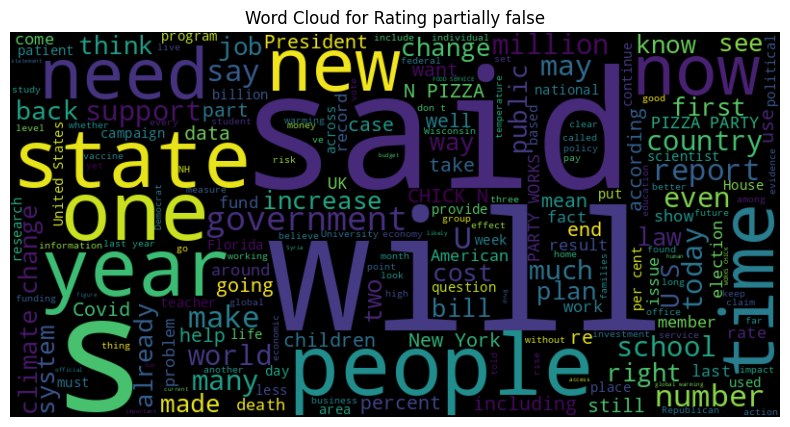

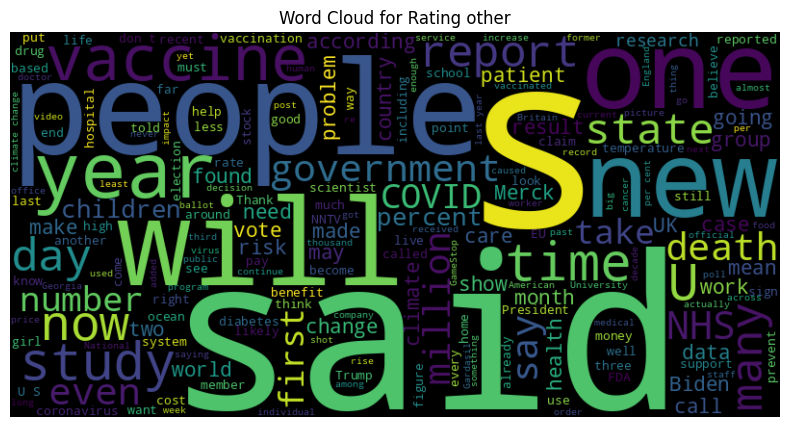

In [9]:
from wordcloud import WordCloud

def generate_word_clouds(df):
    ratings = df['our rating'].unique()
    for rating in ratings:
        text = " ".join(df[df['our rating'] == rating]['text'].tolist())
        wordcloud = WordCloud(width=800, height=400).generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Rating {rating}')
        plt.axis('off')
        plt.show()

generate_word_clouds(train_df)

In [10]:
MODEL_NAME = "roberta-base"
BATCH_SIZE = 16
MAX_TOKEN_LENGTH = 512
EPOCHS = 10
LOG_AND_EVAL_STEPS = 100

In [11]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_ds),
    "test": Dataset.from_pandas(test_ds)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'our rating'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['text', 'our rating'],
        num_rows: 376
    })
})

In [12]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)

id2label = {
    0: "false",
    1: "partially false",
    2: "true",
    3: "other"
}
label2id = {
    "false": 0,
    "partially false": 1,
    "true": 2,
    "other": 3
}

def preprocess_function(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_TOKEN_LENGTH,
        padding="max_length"
    )
    
    if "our rating" in examples:
        tokenized_inputs["labels"] = [label2id[label] for label in examples["our rating"]]
    
    return tokenized_inputs


tokenized_dataset = dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/376 [00:00<?, ? examples/s]

In [13]:
model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    scores = pred.predictions  

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  
    try:
        auc = roc_auc_score(labels, scores, multi_class='ovr', average='weighted') 
    except ValueError:
        auc = None 

    return {
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1
    }

In [15]:
training_args = TrainingArguments(
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    output_dir="./logs",
    report_to="none",
    seed=27,
    data_seed=27,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=LOG_AND_EVAL_STEPS,
    logging_steps=LOG_AND_EVAL_STEPS,
    metric_for_best_model="accuracy"
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()
trainer.evaluate()
trainer.save_model("roberta-base-fake-news")

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Auc,F1 Score
100,1.157800,1.002274,0.587766,None,0.501752
200,0.979800,0.893070,0.635638,None,0.598225
300,0.784600,1.033499,0.651596,None,0.611961
400,0.589300,0.871836,0.683511,None,0.676991
500,0.380100,1.108380,0.699468,None,0.689025
600,0.234400,1.329235,0.712766,None,0.706743
700,0.116200,1.402003,0.699468,None,0.700745
800,0.048400,1.717911,0.702128,None,0.704102
900,0.033900,1.727794,0.718085,None,0.720059


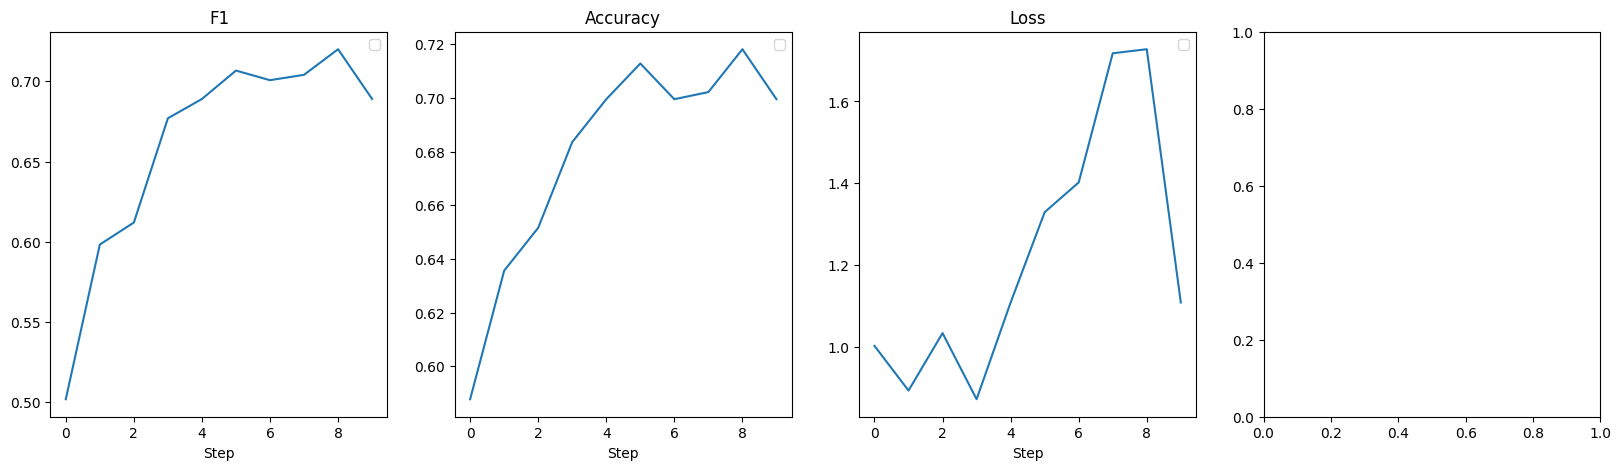

Accuracy values at each logged step: [0.58776596 0.6356383  0.65159574 0.68351064 0.69946809 0.71276596
 0.69946809 0.70212766 0.71808511 0.69946809]


In [17]:
history = pd.DataFrame(trainer.state.log_history).dropna(subset=["eval_loss"]).set_index("step")

histories = {
    "F1": history['eval_f1_score'].values,
    "Accuracy": history['eval_accuracy'].values,
    "Loss": history['eval_loss'].values
}

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["F1", "Accuracy", "Loss"]):
    ax[i].plot(histories[metric])
    ax[i].set_title(metric)
    ax[i].set_xlabel("Step")
    ax[i].legend()

plt.show()    
accuracy_values = history['eval_accuracy'].values
print("Accuracy values at each logged step:", accuracy_values)

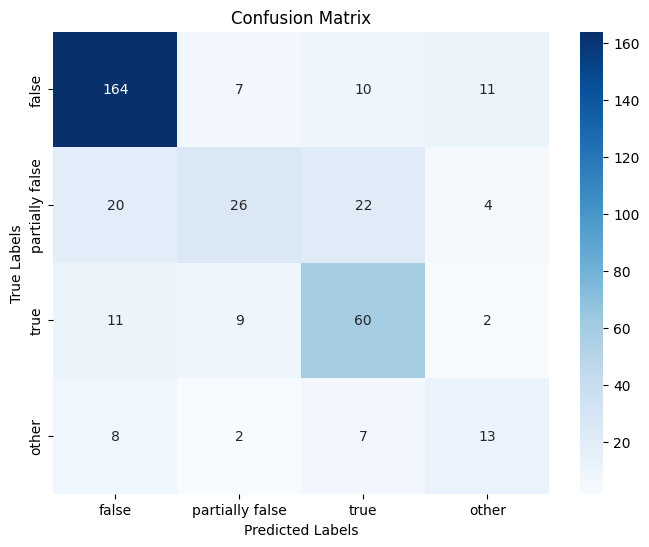

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(tokenized_dataset["test"])
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, pred_labels)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=id2label.values(), yticklabels=id2label.values())
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy on test dataset: {accuracy}")

Accuracy on test dataset: 0.699468085106383
